## Methods
1 - Feed Random Noise and reconstruct the data

2 - Start with clean data, keep adding on noise slowly

3 - Reduce dimension - Done


Use argmax for classification - dont directly correlate/calculate loss on the logits - Currently directly correlating the logits

In [1]:
import torch.nn.functional as F
import torch
from torch_geometric.nn import Sequential, GCNConv

import numpy as np
from pgmpy.metrics import correlation_score
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from scipy.stats import chi2_contingency
import pandas as pd

import bnlearn as bn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# from torch_geometric.nn.models import GAT
from torch_geometric.nn import GATConv, GATv2Conv, Linear
from torch_geometric.data import Data
from torch_geometric.explain import AttentionExplainer, ModelConfig, ExplainerConfig, Explainer, GNNExplainer

In [3]:
def undirected_SHD(g1, g2):
    g1 = np.tril(((g1 + g1.T) > 0).astype(int))
    g2 = np.tril(((g2 + g2.T) > 0).astype(int))
    return np.sum(np.abs(g1-g2))

In [4]:
def comb_SHD(g1, g2):
    return np.sum(np.abs(g1 - g2)), undirected_SHD(g1,g2)

In [5]:
num_samples = 10000
file_name = "asia"
model_asia = bn.import_DAG("BIFs/" + file_name + ".bif")
df_asia = bn.sampling(model_asia, n=num_samples)
# df_asia = df_asia.drop(file_name, axis=1)
nodes_orig = list(model_asia['adjmat'].columns)
asia_dag = DAG(model_asia['adjmat'])

[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.


In [6]:
df_asia

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,0,1,0,1,1,0
1,1,1,1,1,1,1,1,1
2,1,1,0,1,0,1,1,0
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...
9995,1,1,0,1,1,1,1,1
9996,1,1,1,1,1,1,1,1
9997,1,1,0,1,1,1,1,1
9998,1,1,1,1,1,1,1,1


In [7]:
df_asia.T.to_numpy().shape

(8, 10000)

[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


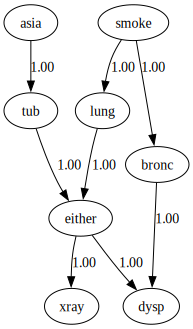

In [869]:
bn.plot_graphviz(model_asia)

In [870]:
df_asia.to_numpy()

array([[1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 0, 1, 0, 1, 1, 0],
       [1, 1, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1,

In [871]:
edge_index = []
for i in range(len(df_asia.columns)):
    for j in range(i+1, len(df_asia.columns)):
        edge_index.append([i,j])
        edge_index.append([j,i])
edge_index = torch.tensor(np.array(edge_index))

In [944]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads, add_self_loops=False)
        self.lin1 = Linear(hidden_channels * heads, 5000)
        self.lin2 = Linear(5000, out_channels)
        self.att_wt = None

    def forward(self, x, edge_index, return_att = False):
        if return_att:
            x, att_wt = self.conv1.forward(x, edge_index, return_attention_weights=True)
            self.att_wt = att_wt
        else:
            x= self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.softmax(x, dim=1)
        return x
        x = F.relu(x)
        # print(x.shape)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        # print(x.shape)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.softmax(x, dim=1)
        # print(x.shape)
        return x

In [945]:
data = Data()

In [946]:
data.x = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples))
# data.x = torch.rand((len(df_asia.columns), 100))
data.edge_index = edge_index.t().contiguous()

In [947]:
data

Data(x=[8, 100], edge_index=[2, 56])

In [948]:
model = GAT(data.x.shape[1], 100, num_samples, heads=data.num_edges-2)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
loss_fn = torch.nn.CrossEntropyLoss()

In [949]:
data.x.shape

torch.Size([8, 100])

In [951]:
model(data.x, data.edge_index)

tensor([[0.0100, 0.0100, 0.0098, 0.0098, 0.0100, 0.0104, 0.0103, 0.0101, 0.0096,
         0.0102, 0.0103, 0.0098, 0.0099, 0.0097, 0.0105, 0.0096, 0.0098, 0.0096,
         0.0099, 0.0103, 0.0101, 0.0099, 0.0099, 0.0095, 0.0092, 0.0104, 0.0101,
         0.0102, 0.0099, 0.0100, 0.0099, 0.0101, 0.0098, 0.0097, 0.0093, 0.0103,
         0.0097, 0.0097, 0.0106, 0.0099, 0.0099, 0.0104, 0.0106, 0.0100, 0.0103,
         0.0098, 0.0103, 0.0103, 0.0097, 0.0101, 0.0107, 0.0099, 0.0096, 0.0107,
         0.0104, 0.0102, 0.0102, 0.0100, 0.0099, 0.0097, 0.0095, 0.0096, 0.0100,
         0.0103, 0.0101, 0.0102, 0.0103, 0.0101, 0.0099, 0.0101, 0.0102, 0.0104,
         0.0100, 0.0097, 0.0105, 0.0100, 0.0102, 0.0103, 0.0096, 0.0098, 0.0099,
         0.0100, 0.0101, 0.0098, 0.0096, 0.0099, 0.0101, 0.0097, 0.0103, 0.0095,
         0.0104, 0.0097, 0.0097, 0.0102, 0.0096, 0.0103, 0.0103, 0.0098, 0.0099,
         0.0102],
        [0.0100, 0.0100, 0.0098, 0.0098, 0.0100, 0.0104, 0.0103, 0.0101, 0.0096,
         0

In [952]:
true_vals = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples))

In [953]:
model

GAT(
  (conv1): GATv2Conv(100, 100, heads=54)
  (lin1): Linear(5400, 5000, bias=True)
  (lin2): Linear(5000, 100, bias=True)
)

In [954]:
true_vals.shape

torch.Size([8, 100])

In [955]:
target.shape

torch.Size([8, 8])

In [956]:
model.train()
losses = []
for i in tqdm(range(400)):
    # if i % 10 == 0 and i>0:
    #     noise_val = torch.randn((data.num_nodes, num_samples)) * float(i)
    #     data.x = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples)) + noise_val
    
    optim.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss1 = loss_fn(true_vals, out)
    loss1.backward()
    
    optim.step()
    # scheduler.step()
    losses.append(loss1.item())


00%|█████████████████████████████████████████| 400/400 [00:34<00:00, 11.51it/s]

In [957]:
model(data.x, data.edge_index)

tensor([[2.9936e-08, 2.4371e-08, 1.6328e-02, 3.1635e-03, 8.2068e-11, 7.0472e-10,
         1.2388e-09, 4.0271e-10, 2.7570e-10, 5.5353e-03, 3.3636e-02, 1.6116e-10,
         1.4549e-09, 2.0252e-11, 4.8351e-02, 3.9711e-10, 6.5482e-10, 2.2203e-08,
         7.1625e-03, 3.0832e-02, 4.6871e-08, 2.4552e-11, 1.8984e-02, 2.6771e-08,
         1.5145e-03, 8.2829e-08, 1.3753e-02, 3.7277e-08, 9.9645e-03, 4.2646e-03,
         7.0268e-03, 2.1045e-10, 2.5665e-02, 2.2192e-10, 1.3567e-10, 9.9980e-10,
         4.5763e-11, 2.7225e-08, 4.2433e-08, 4.6945e-10, 2.1808e-10, 4.8243e-10,
         3.2705e-02, 7.6800e-03, 8.6205e-10, 2.8857e-02, 3.4910e-10, 5.8158e-10,
         3.9836e-10, 4.4203e-08, 1.1668e-01, 6.1056e-10, 1.8788e-10, 5.3088e-10,
         2.4666e-10, 6.6084e-02, 7.7166e-10, 1.0183e-09, 5.6532e-10, 5.6449e-10,
         3.5058e-03, 2.4634e-08, 1.0916e-02, 1.2431e-01, 4.3620e-10, 8.8984e-03,
         4.2922e-10, 4.8659e-10, 2.0970e-10, 1.1723e-10, 5.1415e-10, 6.8436e-10,
         4.4391e-08, 3.7159e

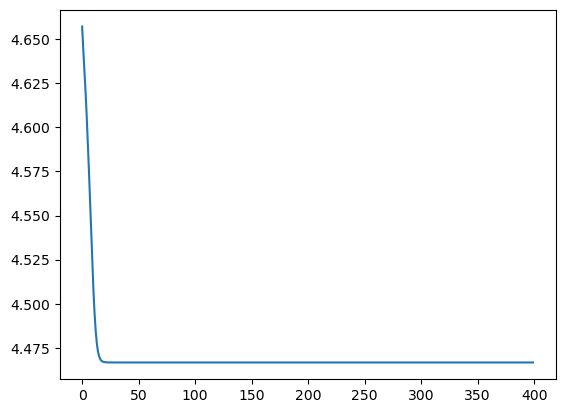

In [911]:
plt.plot(losses)

In [912]:
min(losses)

4.466736793518066

In [913]:
model.conv1.att[0].shape

torch.Size([54, 100])

In [914]:
explainer = Explainer(
    model = model, 
    explanation_type="model",
    algorithm=AttentionExplainer(reduce="mean"),
    node_mask_type=None,
    edge_mask_type='object',
    model_config = ModelConfig(
        mode='binary_classification',
        task_level='edge',
        return_type='raw'
    )
)

In [915]:
explanation = explainer(
    data.x, data.edge_index
)

In [916]:
explanation.available_explanations

['edge_mask']

In [917]:
explanation['edge_mask'].shape

torch.Size([56])

In [918]:
explanation['edge_mask'].shape

torch.Size([56])

In [919]:
data.edge_index.shape

torch.Size([2, 56])

In [920]:
temp_adj = np.zeros((data.num_nodes, data.num_nodes))
for i in range(len(data.edge_index[0])):
    temp_adj[data.edge_index[0][i]][data.edge_index[1][i]] = explanation['edge_mask'][i].item()

In [921]:
temp_adj

array([[0.        , 0.16210164, 0.15431093, 0.16194096, 0.15237582,
        0.16194096, 0.16171554, 0.15249775],
       [0.16303505, 0.        , 0.15546629, 0.16324057, 0.15338284,
        0.16324057, 0.16298831, 0.15357712],
       [0.12456407, 0.12450361, 0.        , 0.1245193 , 0.1216246 ,
        0.1245193 , 0.12479065, 0.12208308],
       [0.16290747, 0.1632719 , 0.15582515, 0.        , 0.15349478,
        0.16318467, 0.16299412, 0.15373643],
       [0.110513  , 0.11047507, 0.10984134, 0.11063894, 0.        ,
        0.11063894, 0.11097825, 0.11043555],
       [0.16290747, 0.1632719 , 0.15582515, 0.16318467, 0.15349478,
        0.        , 0.16299412, 0.15373643],
       [0.16282994, 0.16320239, 0.15617526, 0.16319883, 0.15362139,
        0.16319883, 0.        , 0.15393366],
       [0.113243  , 0.11317348, 0.11255587, 0.11327676, 0.11200584,
        0.11327676, 0.11353899, 0.        ]])

In [922]:
upper_t = np.triu(temp_adj)
lower_t = np.tril(temp_adj)

In [923]:
upper_t

array([[0.        , 0.16210164, 0.15431093, 0.16194096, 0.15237582,
        0.16194096, 0.16171554, 0.15249775],
       [0.        , 0.        , 0.15546629, 0.16324057, 0.15338284,
        0.16324057, 0.16298831, 0.15357712],
       [0.        , 0.        , 0.        , 0.1245193 , 0.1216246 ,
        0.1245193 , 0.12479065, 0.12208308],
       [0.        , 0.        , 0.        , 0.        , 0.15349478,
        0.16318467, 0.16299412, 0.15373643],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11063894, 0.11097825, 0.11043555],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.16299412, 0.15373643],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.15393366],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [924]:
lower_t

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.16303505, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.12456407, 0.12450361, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.16290747, 0.1632719 , 0.15582515, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.110513  , 0.11047507, 0.10984134, 0.11063894, 0.        ,
        0.        , 0.        , 0.        ],
       [0.16290747, 0.1632719 , 0.15582515, 0.16318467, 0.15349478,
        0.        , 0.        , 0.        ],
       [0.16282994, 0.16320239, 0.15617526, 0.16319883, 0.15362139,
        0.16319883, 0.        , 0.        ],
       [0.113243  , 0.11317348, 0.11255587, 0.11327676, 0.11200584,
        0.11327676, 0.11353899, 0.        ]])

In [925]:
adj_1 = lower_t - upper_t.T
thresh = np.max(np.abs(adj_1)) - 0.5 * np.std(np.abs(adj_1))
new_adj = np.zeros((data.num_nodes, data.num_nodes))

In [926]:
for i in range(len(adj_1)):
    for j in range(0, i):
        if i==j:
            continue
        if adj_1[i][j] > thresh:
            new_adj[j][i] = 1
        elif np.abs(adj_1[i][j]) > thresh:
            new_adj[i][j] = 1

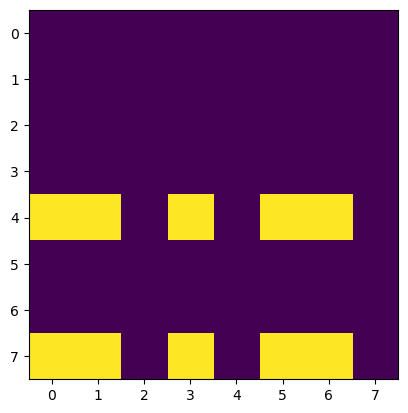

In [927]:
plt.imshow(new_adj)

In [928]:
g = nx.DiGraph(new_adj, nodes=df_asia.columns)

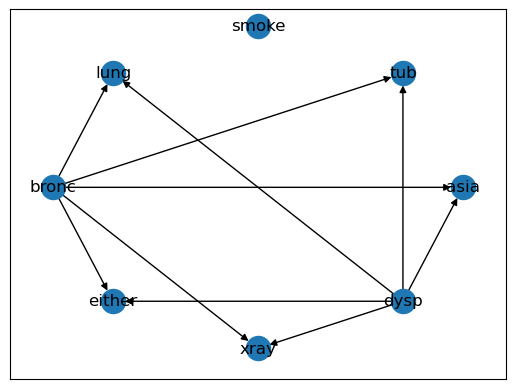

In [929]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:df_asia.columns[i] for i in range(len(g.nodes))
})

In [930]:
comb_SHD(new_adj, model_asia['adjmat'].astype(int).to_numpy())

(18.0, 16)

In [931]:
data.edge_index.shape

torch.Size([2, 56])

In [932]:
explanation['edge_mask'].shape

torch.Size([56])

TypeError: Invalid shape (56,) for image data

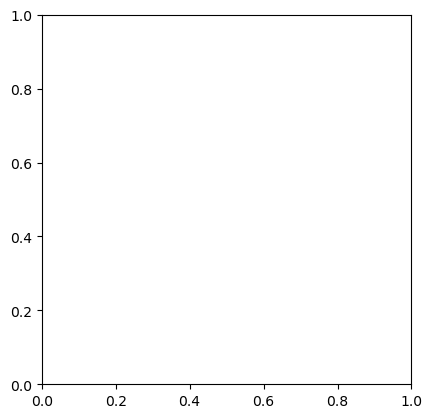

In [933]:
plt.imshow(explanation['edge_mask'])

In [934]:
max(explanation['edge_mask'])

tensor(0.1633)

In [935]:
torch.std(explanation['edge_mask'])

tensor(0.0218)

In [936]:
torch.mean(explanation['edge_mask'])

tensor(0.1429)

In [937]:
att_thresh = (explanation['edge_mask'] > torch.mean(explanation['edge_mask']) + 0.9 * torch.std(explanation['edge_mask'])).detach().numpy().astype(int)
# att_thresh = explanation['edge_mask'] == max(explanation['edge_mask'])

In [938]:
temp_adj = np.zeros((data.num_nodes, data.num_nodes), dtype=int)
for i in range(len(att_thresh)):
    if att_thresh[i] == 1:
        print(edge_index[i].detach().numpy())
        idx = edge_index[i].detach().numpy()
        temp_adj[idx[1]][idx[0]] = 1

[1 0]
[3 0]
[5 0]
[6 0]
[1 3]
[3 1]
[1 5]
[5 1]
[1 6]
[6 1]
[3 5]
[5 3]
[3 6]
[6 3]
[5 6]
[6 5]


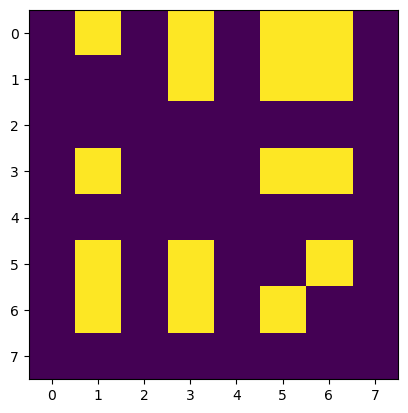

In [939]:
plt.imshow(temp_adj)

In [940]:
comb_SHD(temp_adj, model_asia['adjmat'].astype(int).to_numpy())

(16, 10)

In [941]:
g = nx.DiGraph(temp_adj, nodes=df_asia.columns)

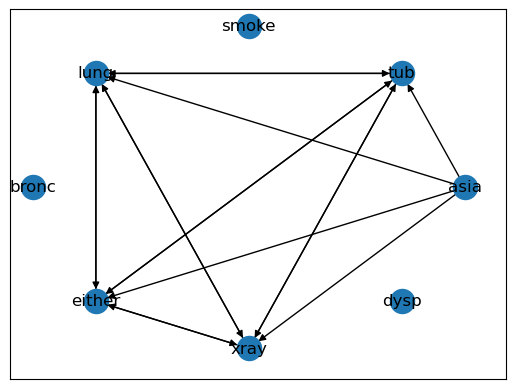

In [942]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:df_asia.columns[i] for i in range(len(g.nodes))
})

In [943]:
explanation.visualize_graph(node_labels=df_asia.columns)

In [862]:
max(losses)

4.538610458374023

In [863]:
min(losses)

4.493226051330566

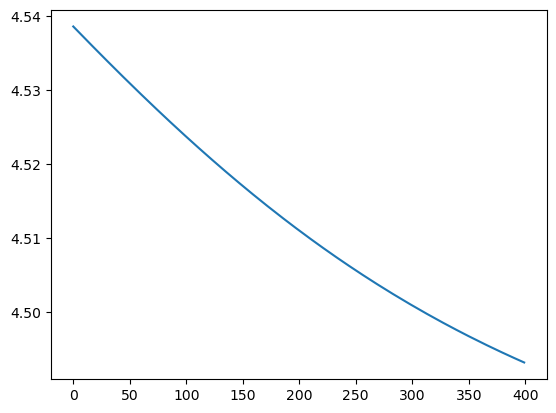

In [864]:
plt.plot(losses)